In [1]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import os

from pysurvival.utils.display import correlation_matrix
from pysurvival.models.survival_forest import RandomSurvivalForestModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import compare_to_actual
from pysurvival.utils.display import integrated_brier_score

from sklearn.model_selection import StratifiedKFold
from statistics import mean 
from statsmodels.stats.outliers_influence import variance_inflation_factor   
from lifelines import CoxPHFitter

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
sns.set()
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

# This is from Yaoting's old code setting up the data

In [2]:
clinical_data=pd.read_excel('WithoutMRNEndometrial_TextureFeatures_09182019.xlsx')
other_data=pd.read_excel('1.20.20 DeIdentified_HG_CT_JJM_AS_Clinical Variables_Final.xlsx')

In [3]:
# in this data sets certain rows are excluded so we have to remove them 
raddata=clinical_data.drop([4, 7, 11, 13, 23, 25, 29, 36, 41, 44, 47, 61, 62, 63, 64, 68, 76, 88, 94, 96, 
                          108, 133, 135, 140, 142]).reset_index(drop=True)
o_data=other_data.drop([4,7, 11, 13, 23, 25, 29, 36, 41, 44, 47, 61, 62, 63, 64, 68, 76, 88, 94, 96, 
                          108, 133, 135, 140, 142]).reset_index(drop=True)
o_data
raddata.columns
coo=pd.DataFrame()
raddata2=raddata.drop(columns=['De identified Study ID'])
raddata2

,GLCM1,GLCM2,GLCM3,GLCM4,GLCM5,GLCM6,GLCM7,GLCM8,GLCM9,GLCM10,...,ACM2_10,ACM2_11,ACM2_12,ACM2_13,ACM2_14,ACM2_15,ACM2_16,ACM2_17,ACM2_18,ACM2_19
0,0.026256,4.333412,0.449950,3.917603,0.454955,18.285737,11.337002,3.752016,5.716646,1.820537,...,8.721173,2.940614,-0.148826,0.818354,0.593029,15.073033,1589.851794,25079.738554,4.739398,0.986655
1,0.050280,2.314190,0.484697,2.424970,0.537827,17.646685,7.385692,3.347634,4.862031,0.980414,...,13.201337,3.010564,-0.199530,0.884071,0.685592,22.045709,1375.243100,22262.287867,4.737088,0.986307
2,0.023361,5.228412,0.398057,4.528518,0.411689,14.291180,12.885660,3.826931,5.966786,2.091924,...,15.510645,3.415731,-0.087748,0.692718,0.457665,29.858372,1154.498568,18661.617962,5.744309,0.992419
3,0.039554,1.855517,0.711033,3.394799,0.580393,17.935818,11.723678,3.712137,5.129299,0.836158,...,10.880541,2.965569,-0.170623,0.851561,0.672977,17.817663,1262.648674,20244.421621,4.899353,0.986331
4,0.047469,1.912943,0.601263,2.375858,0.567263,22.745457,7.590489,3.470541,4.902669,0.831977,...,10.105123,3.008932,-0.154445,0.826874,0.615075,17.461522,1611.613851,26946.037976,4.589336,0.984273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,0.030961,3.329703,0.451058,3.087595,0.476773,18.400621,9.020677,3.600778,5.457496,1.359409,...,13.744894,3.237901,-0.117999,0.762980,0.544010,24.375379,1216.030259,19845.283280,5.463958,0.990320
128,0.029211,3.481393,0.501623,3.940367,0.474784,12.609427,12.280073,3.721832,5.599860,1.440576,...,12.915139,3.192640,-0.128645,0.762071,0.644287,22.532088,1229.523023,18864.092413,2.946259,0.955650
129,0.035093,2.847245,0.527364,3.044318,0.511396,16.492182,9.330027,3.623143,5.368373,1.229950,...,17.301398,3.374493,-0.104464,0.734452,0.527287,31.631916,1131.817162,19269.673532,5.463295,0.991081
130,0.033468,1.997960,0.713680,3.649665,0.556493,16.244867,12.600701,3.835563,5.356900,0.856659,...,15.174270,3.351991,-0.091512,0.711624,0.492463,27.887957,1324.578843,21823.254109,5.910660,0.992627


In [4]:
#preprocessed VIF filtered features
#cols = ['LBP86', 'LBP90', 'LBP92', 'LBP94', 'LBP99', 'LBP101', 'LBP102',
#       'LBP103', 'LBP106', 'LBP107', 'LBP108', 'LBP112', 'LBP116', 'LBP118',
#       'LBP119', 'LBP120', 'FD27', 'FD48', 'FD51', 'FD54', 'ACM1_12']

#yaoting's preprocessed data
cols = ['LBP94', 'LBP101', 'LBP106', 'LBP107', 'LBP108', 'LBP112', 'LBP116',
       'LBP118', 'LBP119', 'LBP120', 'FD27', 'FD51', 'FD54', 'ACM1_12']
raddata2 = raddata2.loc[:, cols]
raddata2

,LBP94,LBP101,LBP106,LBP107,LBP108,LBP112,LBP116,LBP118,LBP119,LBP120,FD27,FD51,FD54,ACM1_12
0,0.008640,0.013356,0.004859,0.004859,0.004132,0.000000,0.010616,0.007653,0.002066,0.000000,9.000000,0.079923,0.068974,-0.072218
1,0.007668,0.048193,0.000000,0.004474,0.002237,0.002237,0.022017,0.025663,0.002237,0.002268,3.333333,0.128958,0.112149,-0.128768
2,0.021092,0.012521,0.004832,0.004832,0.002381,0.002381,0.010747,0.013208,0.000456,0.000000,15.250000,0.056418,0.044223,-0.044774
3,0.016198,0.010369,0.000418,0.000418,0.002021,0.001185,0.009453,0.017735,0.000000,0.001094,15.750000,0.141440,0.121297,-0.076017
4,0.009955,0.005240,0.002404,0.002404,0.000000,0.000000,0.014629,0.011696,0.004484,0.000000,8.000000,0.157050,0.145854,-0.071011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,0.022039,0.010716,0.003116,0.003159,0.003084,0.002702,0.008869,0.014814,0.000392,0.000713,24.500000,0.087100,0.067616,-0.051001
128,0.012268,0.011711,0.001980,0.002713,0.001017,0.000758,0.006853,0.014726,0.001896,0.000630,25.888889,0.055196,0.037529,-0.155972
129,0.015814,0.010354,0.001611,0.003510,0.000773,0.000773,0.008804,0.009672,0.002337,0.000396,31.714286,0.100156,0.067450,-0.041698
130,0.019432,0.016423,0.002315,0.002550,0.001315,0.000583,0.009172,0.014753,0.000963,0.000259,59.888889,0.112976,0.065836,-0.032100


## coo =  clinical outcomes?

In [5]:
coo['time column']=o_data['Time to Recurrence (months)']
coo['event column']=o_data['Recurrence (y/n)']
coo['age']=o_data['Age at Dx']
coo['adjuvalent']=o_data['Adjuvant treatment (y/n)']
coo['Chemo ']=o_data['Chemo (y/n)']
coo['Diabetes']=o_data['Diabetes (y/n)']
coo['Node Status']=o_data['Node Status (+/-)']
coo

,time column,event column,age,adjuvalent,Chemo,Diabetes,Node Status
0,72.866667,0.0,69,1.0,1.0,0.0,0.0
1,57.733333,0.0,71,1.0,1.0,0.0,0.0
2,69.100000,0.0,55,1.0,1.0,0.0,0.0
3,39.233333,0.0,61,1.0,1.0,0.0,0.0
4,20.000000,1.0,63,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
127,22.400000,0.0,64,1.0,1.0,0.0,0.0
128,8.266667,1.0,73,1.0,0.0,1.0,0.0
129,18.666667,0.0,70,1.0,0.0,0.0,0.0
130,20.300000,0.0,68,1.0,1.0,1.0,0.0


In [6]:
# dummyfying variables
#here we use get_dummies to create dummy variables 
test=o_data.loc[:,['Race', 'BMI-Category', 'Histology']]
test2=pd.get_dummies(test['Race'], prefix='race')

test3=pd.get_dummies(test['BMI-Category'], prefix ='BMI')
test4=pd.get_dummies(test['Histology'], prefix='Hist')
new_test=pd.concat([test2, test3, test4], axis=1)
new_test

,race_0.0,race_1.0,race_2.0,race_3.0,race_4.0,BMI_0.0,BMI_1.0,BMI_2.0,Hist_0,Hist_1,Hist_2,Hist_3,Hist_4
0,0,1,0,0,0,0,1,0,0,1,0,0,0
1,0,0,1,0,0,1,0,0,1,0,0,0,0
2,1,0,0,0,0,0,1,0,1,0,0,0,0
3,1,0,0,0,0,1,0,0,1,0,0,0,0
4,0,0,0,0,1,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,1,0,0,0,0,0,1,0,0,1,0,0,0
128,0,0,1,0,0,1,0,0,0,0,1,0,0
129,0,0,1,0,0,1,0,0,1,0,0,0,0
130,1,0,0,0,0,0,1,0,0,0,1,0,0


## this is where the code diverges from original notebook, saving 3 feature sets (clinical data, radiomics, raciomics + clinical data), then performing feature selection and RSF on each differently than the original code

In [66]:
clin_var_only = pd.concat([coo, new_test], axis=1)
radiomics_only = pd.concat([raddata2, coo], axis=1)
rad_and_clin_var = pd.concat([raddata2, coo, new_test], axis=1)

clin_var_only.to_csv('clin_var_only.csv', index=False)
radiomics_only.to_csv('radiomics_only.csv', index=False)
rad_and_clin_var.to_csv('rad_and_clin_var.csv', index=False)

## functions from the liver mets code

In [7]:
def cox_feature_select(data):    
    time_column='time column'
    event_column='event column'
    features=np.setdiff1d(data.columns, [time_column, event_column]).tolist()

    #computing max numer of samples 
    num_samples = data.shape[0]
    max_num_features = math.ceil(num_samples/10)
    print("max =" + str(max_num_features))
    cph = CoxPHFitter()
    cph.fit(data, duration_col = time_column, event_col=event_column)  

    #getting coefficients
    hr = abs(cph.params_)

    filtered_hr = hr.nlargest(n=max_num_features, keep='first')
    index_names = filtered_hr.index

    col_names = []
    for x in range(1,len(index_names)):
        col_names.append(index_names[x])

    col_names.append(time_column)
    col_names.append(event_column)

    filtered_data = data.filter(items=col_names, axis=1)
    
    return filtered_data

 

def calculate_vif_(X, thresh=10):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True
            
    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

# feature selection function by VIF and removing low variance features

def feature_select(file_name):
    data = pd.read_csv(file_name)

    if 'FFLP' in data.columns:
        data['time column']= data['FFLP_in_months']
        data['event column']= data['FFLP']
        data = data.drop(columns = ['FFLP','FFLP_in_months'])

    elif 'AnyHepaticProgression' in data.columns:
        data['time column']= data['TimeToAnyHepaticProgression']
        data['event column']= data['AnyHepaticProgression']
        data = data.drop(columns = ['AnyHepaticProgression','TimeToAnyHepaticProgression'])

    #legacy code, used to be data1=data.drop(columns=['filename'])
    data1=data
    lola=data1.iloc[:,0:255]

    time_column='time column'
    event_column='event column'
    features=np.setdiff1d(data1.columns, [time_column, event_column]).tolist()

    #VIF of 10 means that all the features with R^2 above 0.9 will removed
    X = lola
    data2 = calculate_vif_(X, 25)
    data2[['time column']] = lola[['time column']]


    #removing low variance features
    data_temp = data2
    for cols in data2.columns:
        if np.var(data2[cols]) == 0:
            print('Dropping: ' + cols)
            data_temp = data_temp.drop(columns=cols)

    data2 = data_temp
    
    #feature selecting by taking high odds variables from Cox regression if not enough samples
    data_temp = cox_feature_select(data2)
    data2 = data_temp
    
    # saving a copy to not repeat feature selection again
    processedFileName = 'filtered_' + file_name
    data2.to_csv(processedFileName, index=False)

    return data2

In [12]:
# this can definitely be modularized later

# Gridsearch funciton for random survival forest

def gridsearch(data2, file_name):
    
    time_column='time column'
    event_column='event column'
    
    features=np.setdiff1d(data2.columns, [time_column, event_column]).tolist()
    X = data2[features]

    newX=np.setdiff1d(data2.columns, [event_column]).tolist()
    X=data2[newX]
    E=data2['event column']

    num_tree=(10, 25, 50, 100, 420)
    max_depth=(1, 2, 5, 10, 12, 15)
    min_node=(1, 2, 3, 4, 5, 10, 12, 15, 20)
    k_folds = 5
    
    Xnew = X
    Enew = E
    features2 = features

    num_tree_best = 0
    max_depth_best = 0
    min_node_best = 0
    c_index_best = 0

    for a in num_tree:
        for b in max_depth:
            for c in min_node:
                cc=[]
                kf=StratifiedKFold(n_splits=k_folds, random_state=42, shuffle=True)
                i=1
                for train_index, test_index in kf.split(Xnew,Enew):
                    X1_train, X1_test=Xnew.loc[train_index], Xnew.loc[test_index]
                    X_train, X_test=X1_train[features2], X1_test[features2]
                    T_train, T_test=X1_train['time column'].values, X1_test['time column'].values
                    E_train, E_test=Enew.loc[train_index].values, Enew.loc[test_index].values
                    xst = RandomSurvivalForestModel(num_trees=a) 
                    xst.fit(X_train, T_train, E_train, max_features = 'sqrt', max_depth = b,
                    min_node_size = c, num_threads = -1, 
                    sample_size_pct = 0.80, importance_mode = 'normalized_permutation',
                    seed = None, save_memory=False )
                    from pysurvival.utils.metrics import concordance_index
                    c_index = concordance_index(xst, X_test, T_test, E_test)
                    cc.append(c_index)
                i=i+1
                print(a, b, c, mean(cc))
                if mean(cc) > c_index_best:
                    c_index_best = mean(cc)
                    num_tree_best = a
                    max_depth_best = b
                    min_node_best = c
                    
    # saving a copy to not repeat grisearch again, invalid for gridsearch within CV
    processedFileName = 'gridsearch_' + file_name           
    toDF = [c_index_best, num_tree_best, max_depth_best, min_node_best]
    gridsearchDF = pd.DataFrame(toDF,columns=['Values'])
    gridsearchDF.to_csv(processedFileName)
    
    return (c_index_best, num_tree_best, max_depth_best, min_node_best)

def generate_survival_model(data2, num_tree_best, max_depth_best, min_node_best):
    # retraining with best gridsearch hyperparameters, manually entering them as variables, probably can automate this from picking out max acc
    # Creating the X, T and E inputs
    
    time_column='time column'
    event_column='event column'
    
    features=np.setdiff1d(data2.columns, [time_column, event_column]).tolist()
    X = data2[features]
    newX=np.setdiff1d(data2.columns, [event_column]).tolist()
    
    X=data2[newX]
    E=data2['event column']

    CI = []
    IBS = []

    k_folds = 5
    i=1
    kf=StratifiedKFold(n_splits=k_folds, random_state=42, shuffle=True)
    
    
    for train_index, test_index in kf.split(X,E):
        
        # gridsearch within CV loop, takes a long while, comment if doing gridsearch outside of CV
        # gridsearch_data = pd.concat([X,E], axis=1)
        # (c_index_best, num_tree_best, max_depth_best, min_node_best) = gridsearch(gridsearch_data, "garbageFile")
        
        print('\n {} of kfold {}'.format(i,kf.n_splits)) 
        X1_train, X1_test=X.loc[train_index], X.loc[test_index]
        X_train, X_test=X1_train[features], X1_test[features]
        T_train, T_test=X1_train['time column'].values, X1_test['time column'].values
        E_train, E_test=E.loc[train_index].values, E.loc[test_index].values
        xst = RandomSurvivalForestModel(num_trees=num_tree_best) 
        
        xst.fit(X_train, T_train, E_train, max_features = 'sqrt', max_depth = max_depth_best,
            min_node_size = min_node_best, num_threads = -1, 
            sample_size_pct = 0.63, importance_mode = 'normalized_permutation',
            seed = None, save_memory=False )
        
        c_index = concordance_index(xst, X_test, T_test, E_test)
        results = compare_to_actual(xst, X_test, T_test, E_test, is_at_risk = True,  figure_size=(16, 6), 
                                metrics = ['rmse', 'mean', 'median'])
        ibs = integrated_brier_score(xst, X_test, T_test, E_test, t_max=100, figure_size=(16,6))
        CI.append(c_index)
        IBS.append(ibs)
        print('C-index: {:.2f}'.format(c_index))
        print('IBS: {:.2f}'.format(ibs))           
        i=i+1

    CIAvg = mean(CI)
    CIStd = statistics.stdev(CI)
    IBSAvg = mean(IBS)
    IBSStd = statistics.stdev(IBS)
    
    return(CIAvg, CIStd, IBSAvg, IBSStd)

# main script starts here

In [9]:
rad_only = 'radiomics_only.csv'
clin_var_only = 'clin_var_only.csv'
rad_and_clin_var = 'rad_and_clin_var.csv'

data_list = list()
data_list.extend((rad_only, clin_var_only, rad_and_clin_var))
# file integrity test
for data_name in data_list:
    test  = pd.read_csv(data_name)

Processing: radiomics_only.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: radiomics_only.csv

Computing gridsearch...

10 1 1 0.6551842645278975
10 1 2 0.6397264584570479
10 1 3 0.6474237154452084
10 1 4 0.6179743662409858
10 1 5 0.6034677492853979
10 1 10 0.6502789040097794
10 1 12 0.6736321013084449
10 1 15 0.6247205574284987
10 1 20 0.6685222927076329
10 2 1 0.6705026314319217
10 2 2 0.5454179785541302
10 2 3 0.552249152168398
10 2 4 0.6105598243668533
10 2 5 0.5963278180526405
10 2 10 0.6726808024557613
10 2 12 0.6175166103479046
10 2 15 0.5935566589087021
10 2 20 0.6164755724354876
10 5 1 0.6668411373299703
10 5 2 0.5782316005899767
10 5 3 0.5638497109378491
10 5 4 0.6478526818194374
10 5 5 0.5763975620879046
10 5 10 0.5788712061610652
10 5 12 0.6374703937871634
10 5 15 0.6139101752030011
10 5 20 0.6004380359149218
10 10 1 0.6563847946325065
10 10 2 0.5700742702650025
10 10 3 0.5824466079076046
10 10 4 0.6135465535677473
10 10 5 0.595

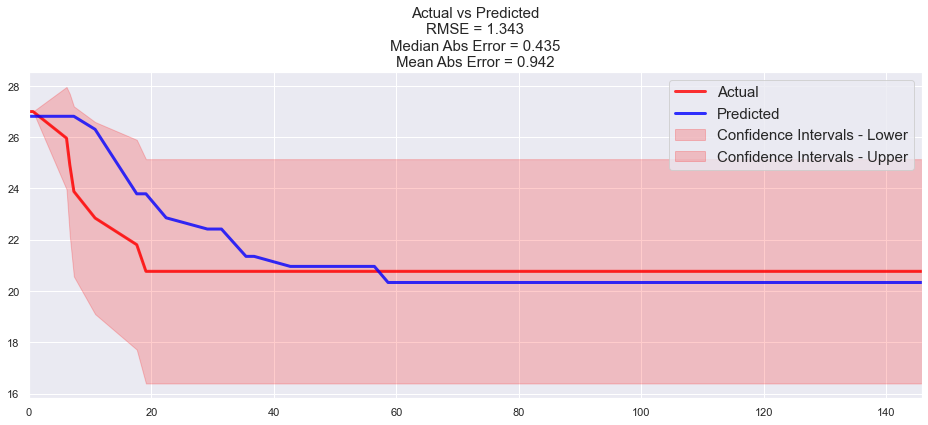

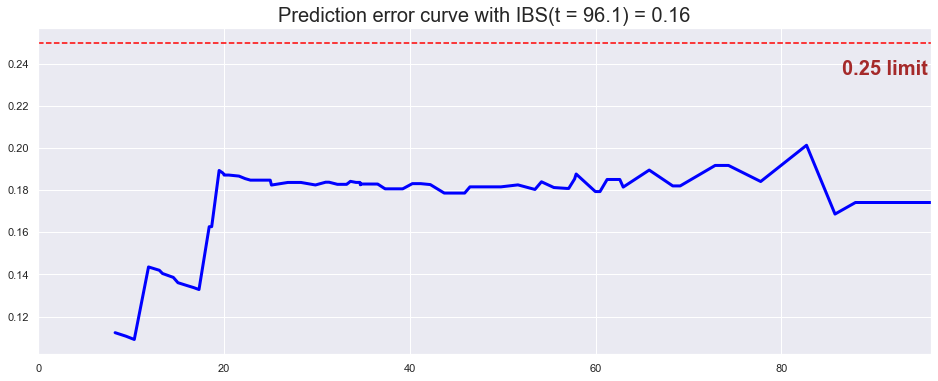

C-index: 0.50
IBS: 0.16

 2 of kfold 5


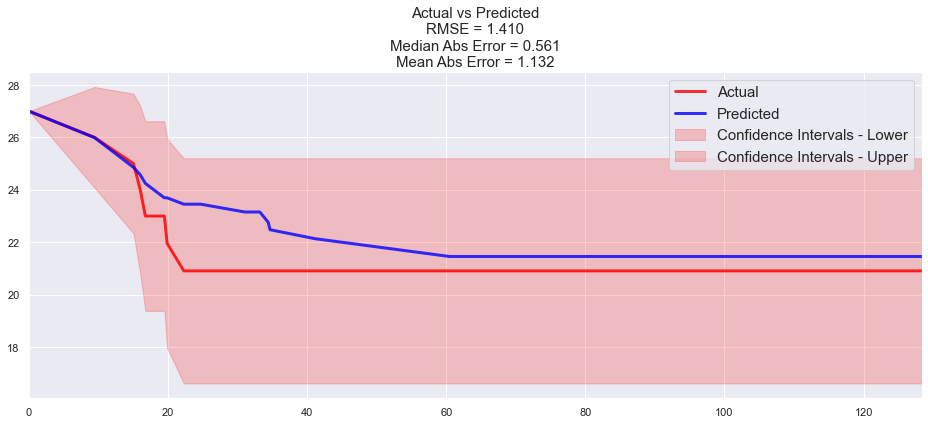

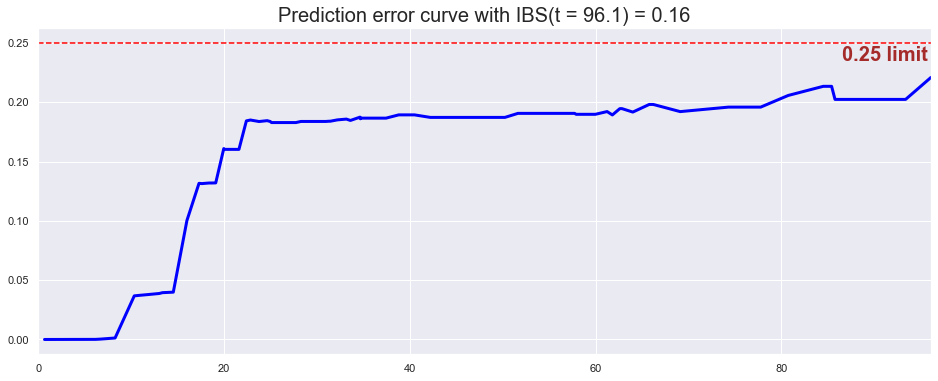

C-index: 0.59
IBS: 0.16

 3 of kfold 5


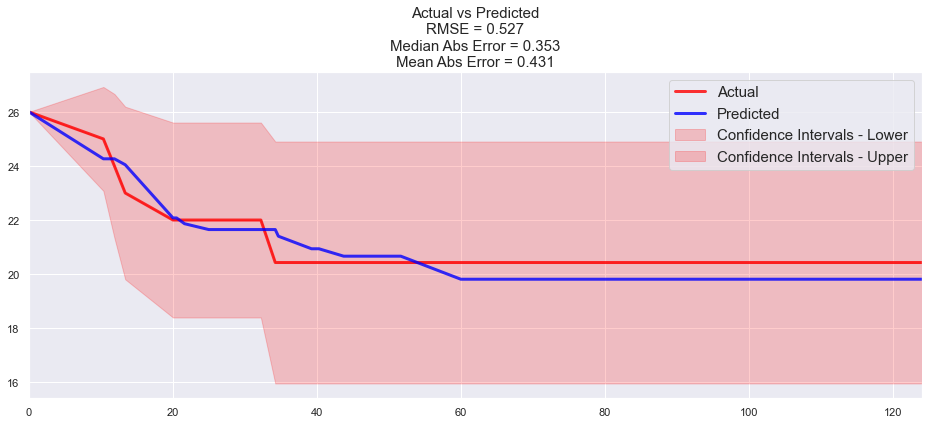

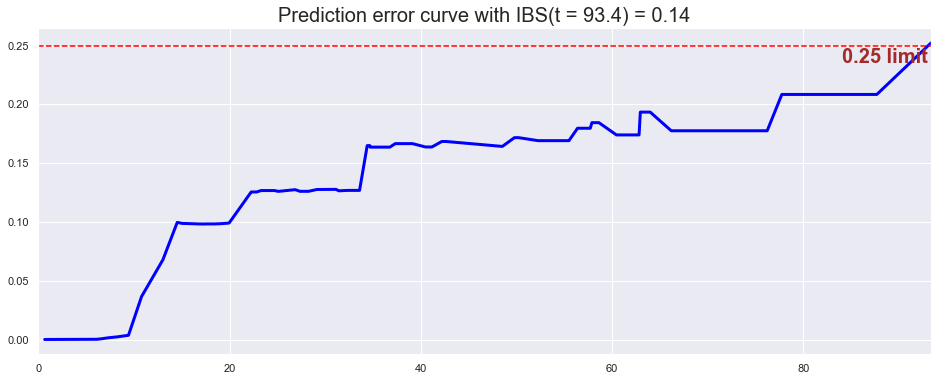

C-index: 0.73
IBS: 0.14

 4 of kfold 5


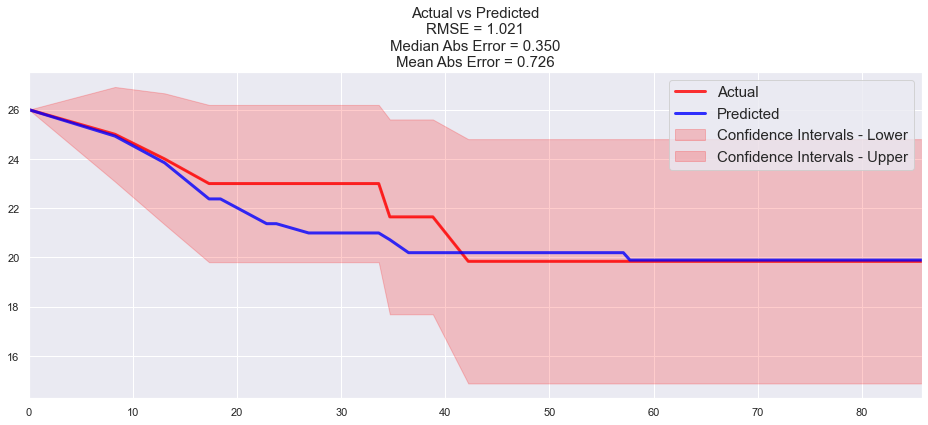

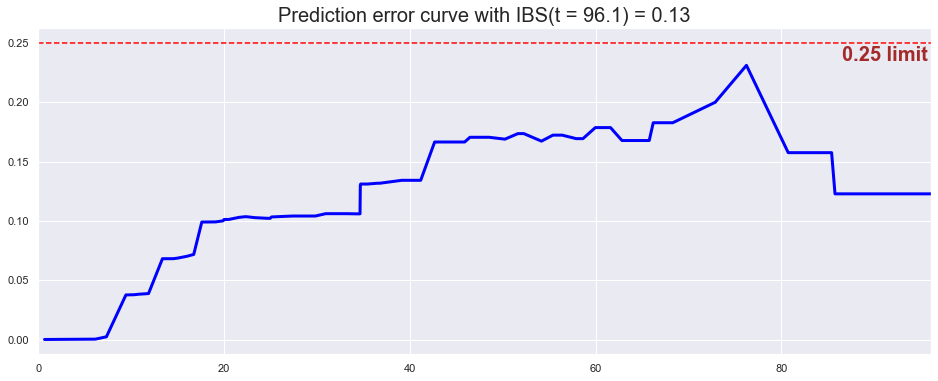

C-index: 0.80
IBS: 0.13

 5 of kfold 5


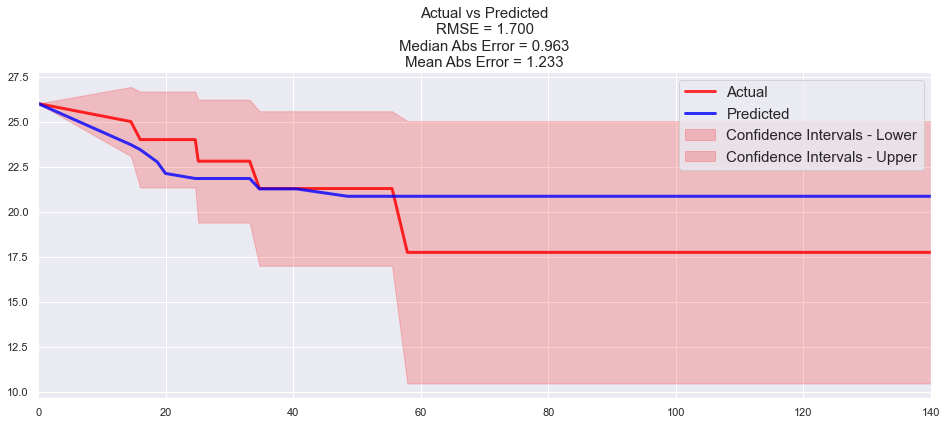

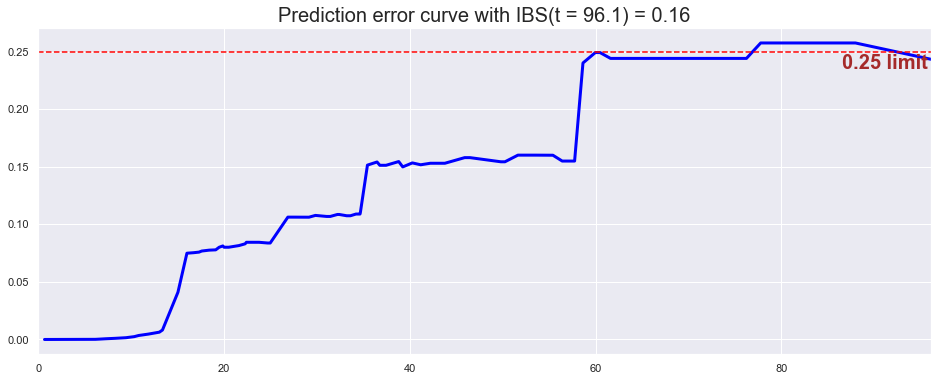

C-index: 0.58
IBS: 0.16

 

Processing: clin_var_only.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: clin_var_only.csv

Computing gridsearch...

10 1 1 0.6012448581156562
10 1 2 0.5867652894958311
10 1 3 0.5896556892285708
10 1 4 0.5679552377867385
10 1 5 0.596002762502103
10 1 10 0.6268812152619885
10 1 12 0.624494316455764
10 1 15 0.5930673480233958
10 1 20 0.6243742358472893
10 2 1 0.6012326193817756
10 2 2 0.584351937318009
10 2 3 0.6038082409073926
10 2 4 0.5502814631296195
10 2 5 0.6033293658047916
10 2 10 0.6422462484717805
10 2 12 0.5578323710070064
10 2 15 0.5978536446322427
10 2 20 0.6429577705468251
10 5 1 0.5435301131204942
10 5 2 0.5692659118620118
10 5 3 0.6362087635005657
10 5 4 0.6357698449299768
10 5 5 0.6459910008801348
10 5 10 0.6317476631734398
10 5 12 0.5592289083845143
10 5 15 0.6034336205824703
10 5 20 0.6262413361885024
10 10 1 0.6104821246406631
10 10 2 0.6275066911438064
10 10 3 0.6255684573768118
10 10 4 0.539503

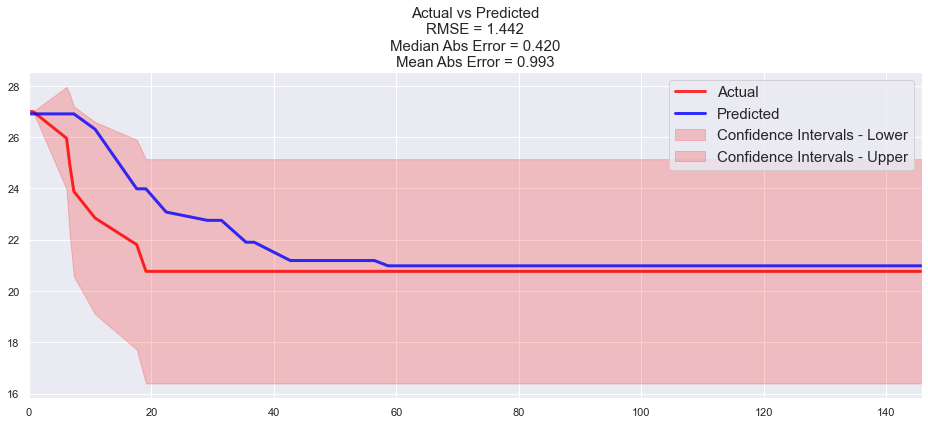

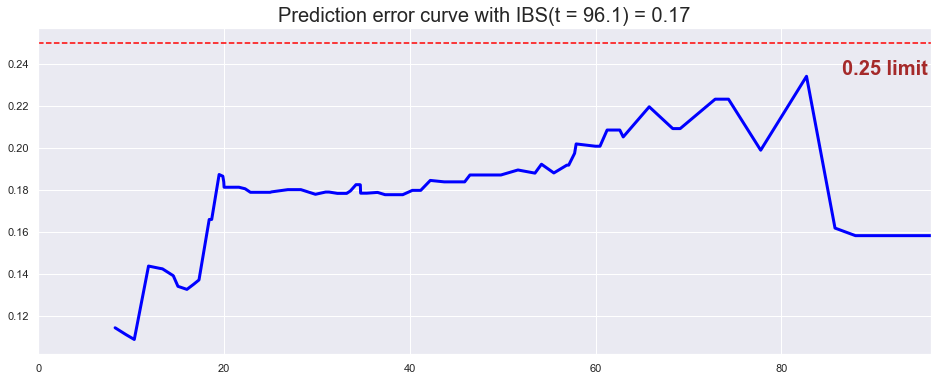

C-index: 0.51
IBS: 0.17

 2 of kfold 5


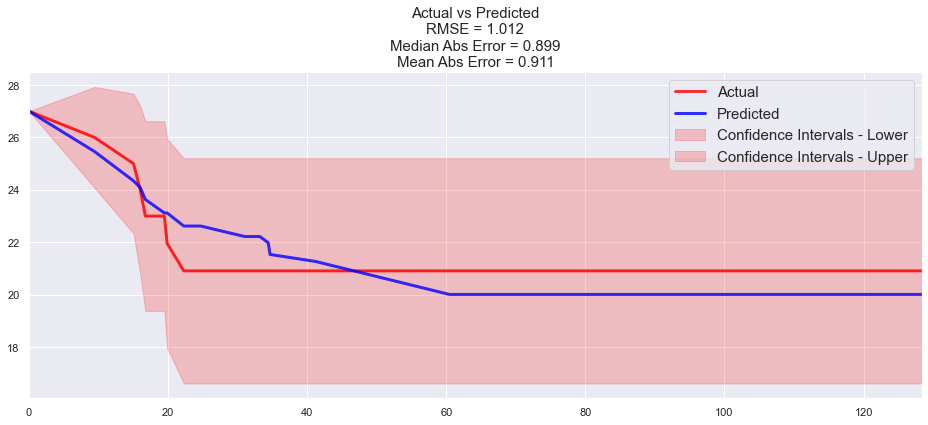

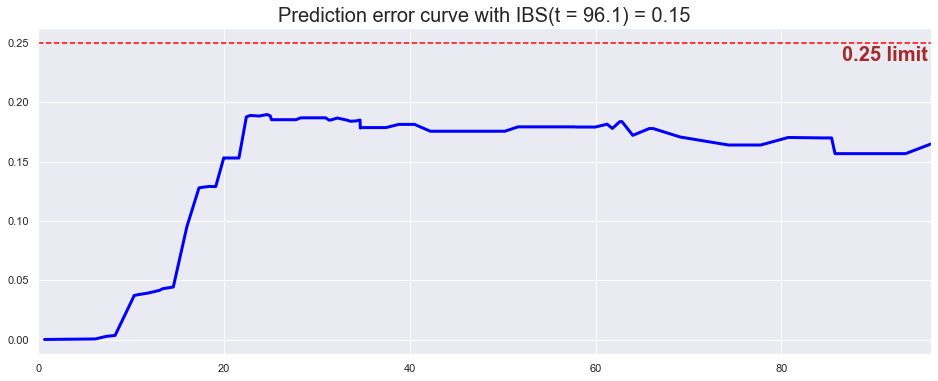

C-index: 0.52
IBS: 0.15

 3 of kfold 5


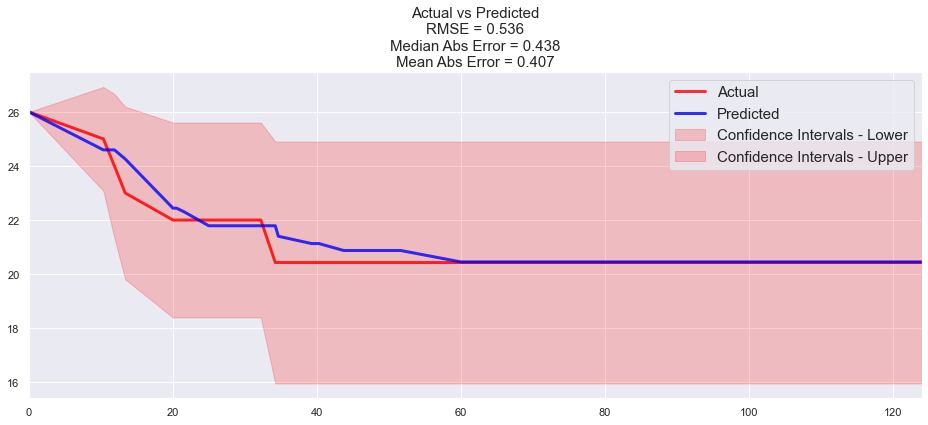

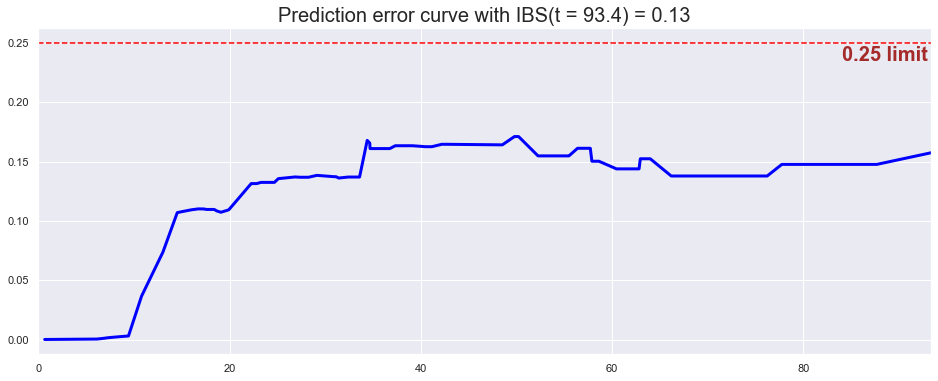

C-index: 0.61
IBS: 0.13

 4 of kfold 5


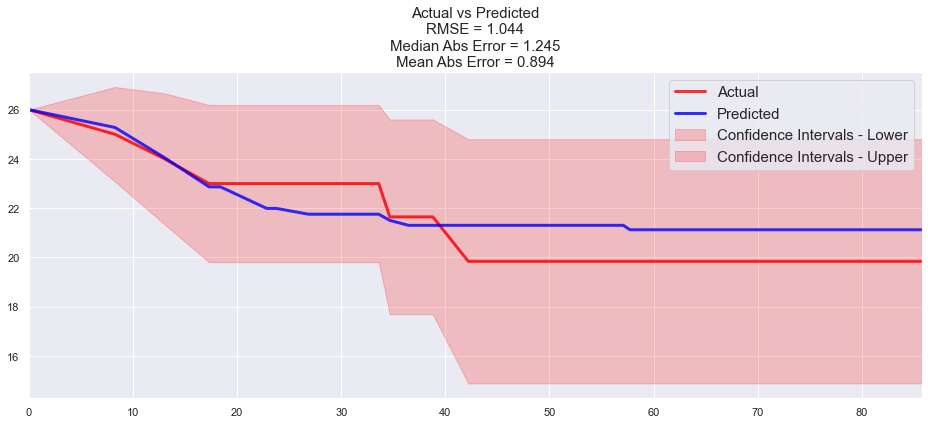

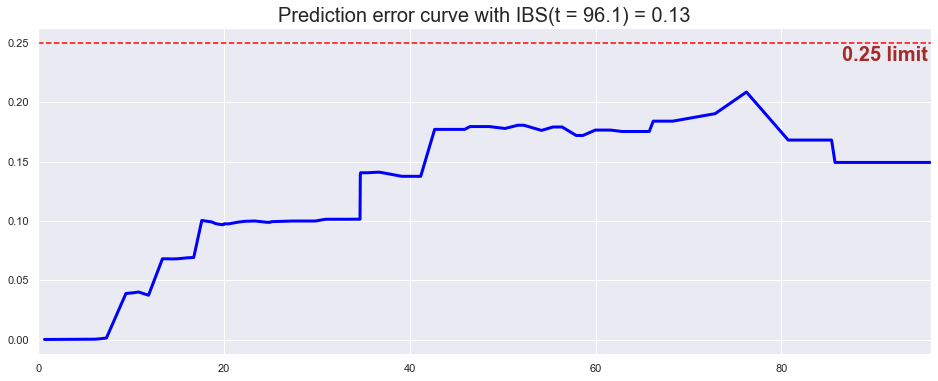

C-index: 0.62
IBS: 0.13

 5 of kfold 5


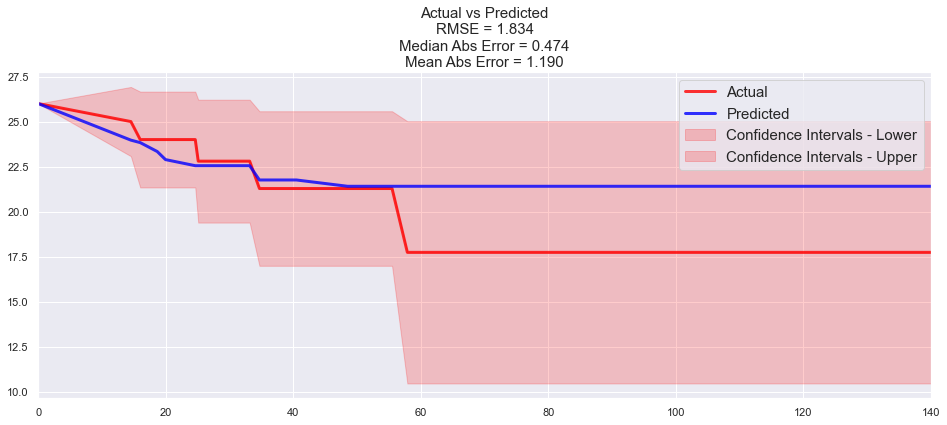

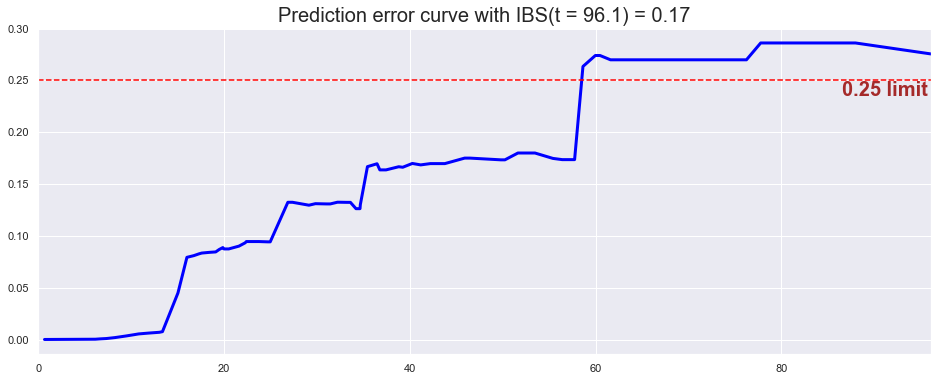

C-index: 0.67
IBS: 0.17

 

Processing: rad_and_clin_var.csv

Feature Selecting... 

Computing feature selection...

dropping 'race_0.0' at index: 21
dropping 'BMI_0.0' at index: 25
dropping 'Hist_0' at index: 27
dropping 'age' at index: 16
Remaining variables:
Index(['LBP94', 'LBP101', 'LBP106', 'LBP107', 'LBP108', 'LBP112', 'LBP116',
       'LBP118', 'LBP119', 'LBP120', 'FD27', 'FD51', 'FD54', 'ACM1_12',
       'time column', 'event column', 'adjuvalent', 'Chemo ', 'Diabetes',
       'Node Status', 'race_1.0', 'race_2.0', 'race_3.0', 'race_4.0',
       'BMI_1.0', 'BMI_2.0', 'Hist_1', 'Hist_2', 'Hist_3', 'Hist_4'],
      dtype='object')
max =14

 

Running gridsearch on: rad_and_clin_var.csv

Computing gridsearch...

10 1 1 0.6751513169389758
10 1 2 0.6704393448605557
10 1 3 0.6645452646768015
10 1 4 0.6743646332136488
10 1 5 0.6849997255122602
10 1 10 0.6700887759810298
10 1 12 0.6562915835266527
10 1 15 0.6536519336418823
10 1 20 0.6462105955291971
10 2 1 0.65516098343539
10 2 2 0.6

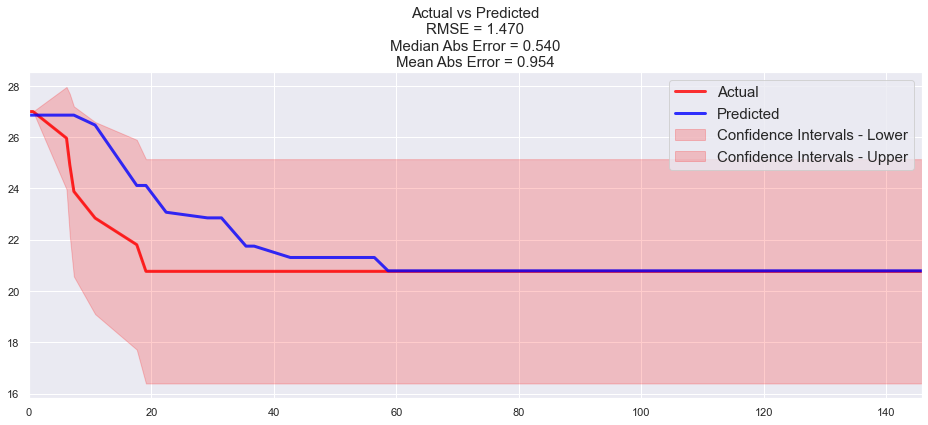

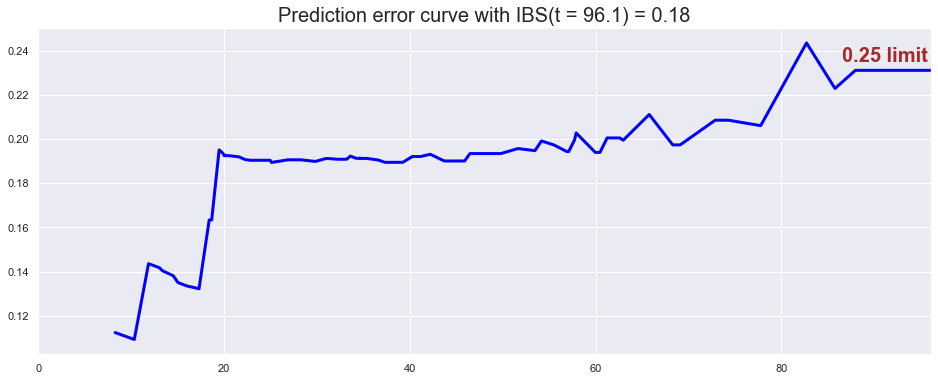

C-index: 0.50
IBS: 0.18

 2 of kfold 5


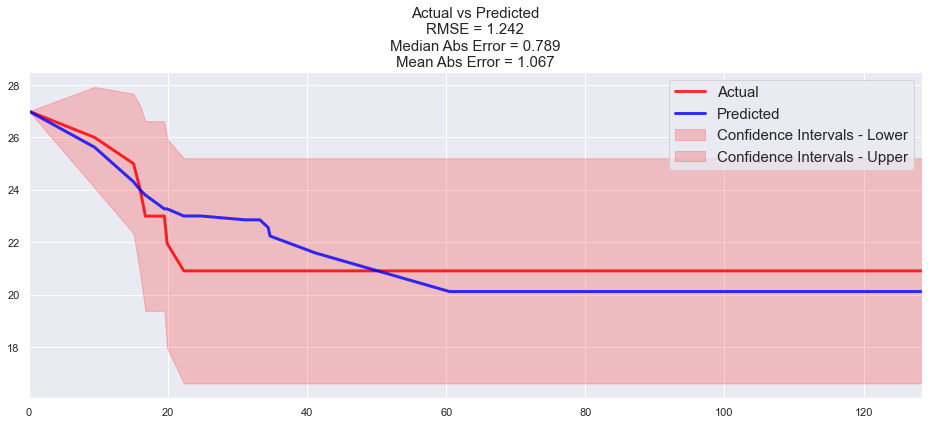

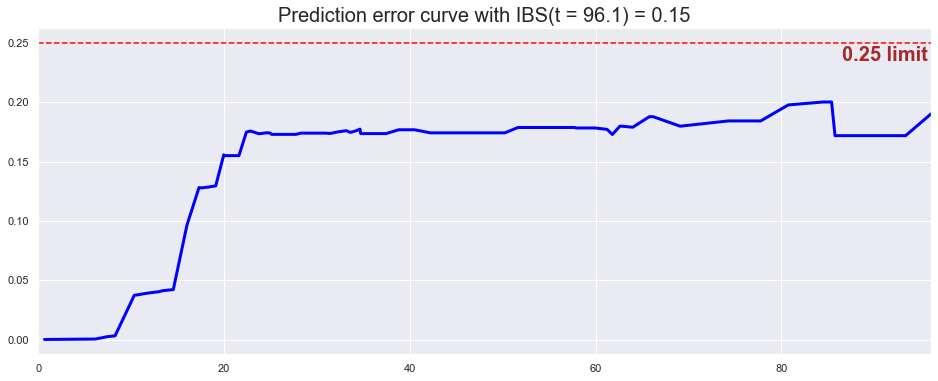

C-index: 0.61
IBS: 0.15

 3 of kfold 5


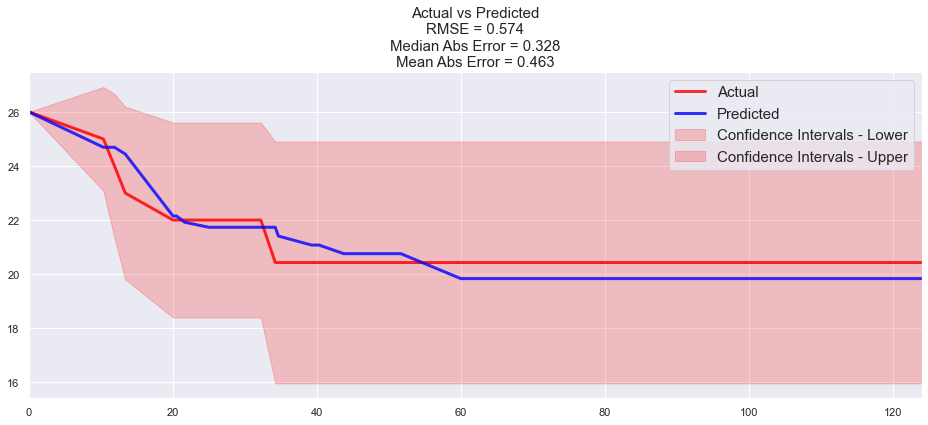

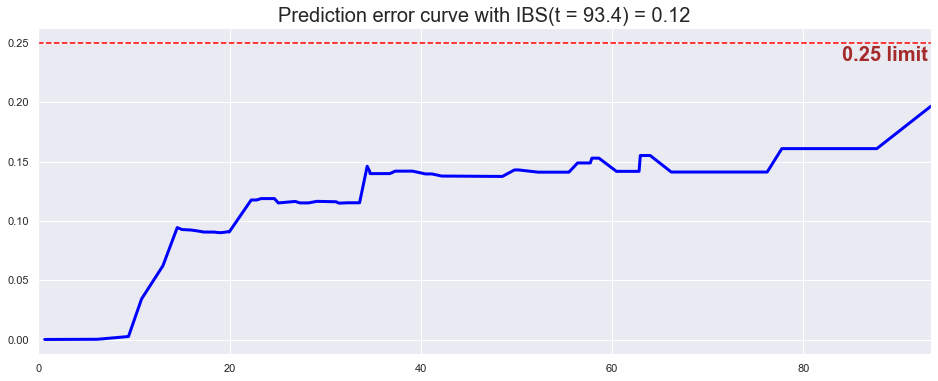

C-index: 0.88
IBS: 0.12

 4 of kfold 5


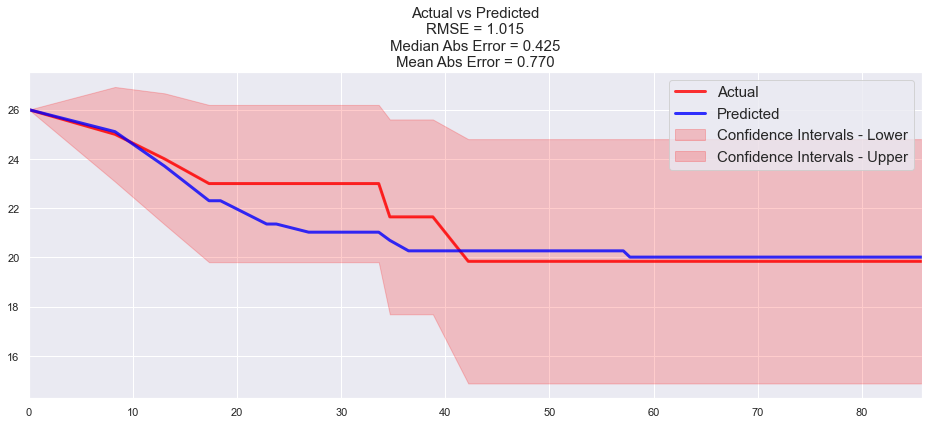

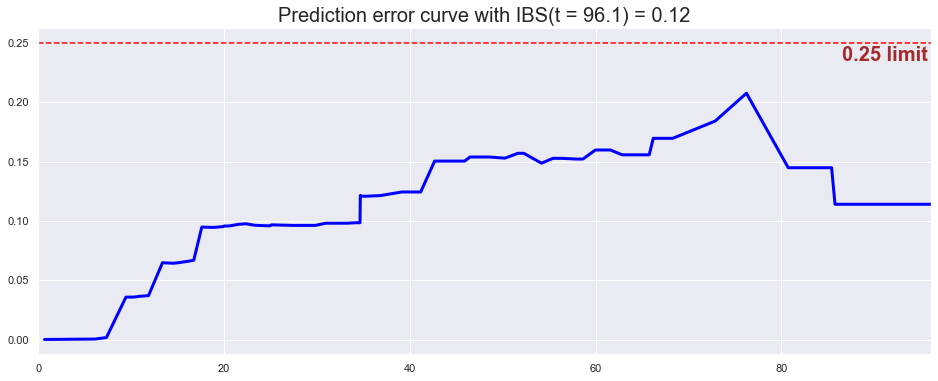

C-index: 0.86
IBS: 0.12

 5 of kfold 5


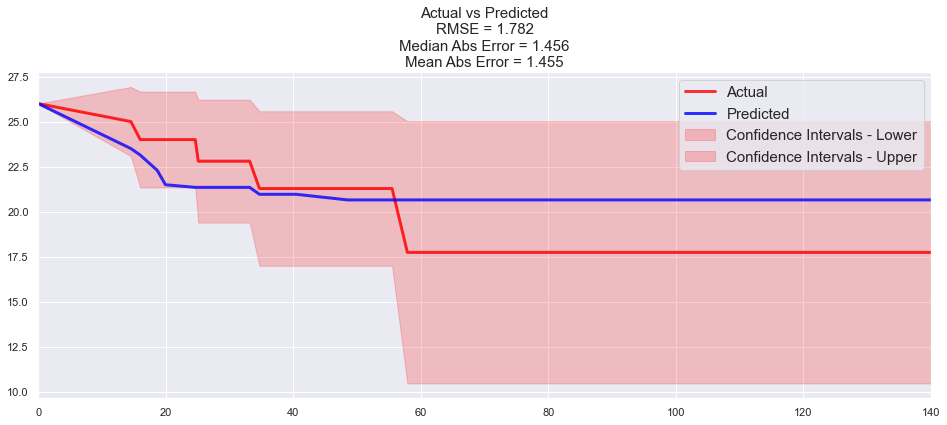

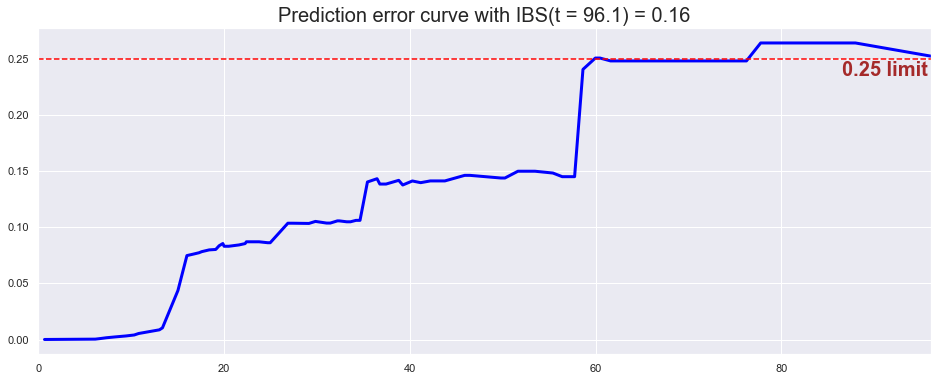

C-index: 0.51
IBS: 0.16

 

                   Data  Best Gridsearch CI    CI Avg    CI STD   IBS Avg  \
0    radiomics_only.csv            0.703333  0.640713  0.121456  0.150276   
1     clin_var_only.csv            0.683943  0.589265  0.068360  0.149057   
2  rad_and_clin_var.csv            0.739697  0.673412  0.186387  0.144190   

    IBS STD  Num Trees  Max Depth  Min Node  
0  0.014127         25          1        20  
1  0.020994         25          5         2  
2  0.025593         25          5        20  


In [76]:
results = []
    
for data_name in data_list:

    # Running feature selection on the data
    
    print('Processing: ' + data_name + '\n')
    processed_file_name = 'filtered_' + data_name 
    
    print('Feature Selecting... \n')
    if(not(os.path.exists(processed_file_name))):
        print('Computing feature selection...\n')
        filtered_data = feature_select(data_name)
    else:
        filtered_data = pd.read_csv(processed_file_name)
        print('Loading existing selected features...\n')
    print('\n \n')

    # running gridsearch
    
    print('Running gridsearch on: ' + data_name + '\n')
    gridsearch_file_name = 'gridsearch_' + data_name 
    
    if(not(os.path.exists(gridsearch_file_name))):
        print('Computing gridsearch...\n')
        (c_index_best, num_tree_best, max_depth_best, min_node_best) = gridsearch(filtered_data, data_name)
        print((c_index_best, num_tree_best,max_depth_best, min_node_best))
    else:
        gridsearch_df = pd.read_csv(gridsearch_file_name)
        
        c_index_best = gridsearch_df['Values'][0]
        num_tree_best = gridsearch_df['Values'][1]
        max_depth_best = gridsearch_df['Values'][2]
        min_node_best = gridsearch_df['Values'][3]
        
        #print(c_index_best)
        print('Loading existing gridsearch hyperparameters...\n')
        
    # generating model form best gridsearch combination

    print('Evaluating K-folds with best hyperparameter combination...\n')
    (CIAvg, CIStd, IBSAvg, IBSStd) = generate_survival_model(filtered_data, num_tree_best, max_depth_best, min_node_best)
    
    results.append([data_name, c_index_best, CIAvg, CIStd, IBSAvg, IBSStd, num_tree_best, max_depth_best, min_node_best])
    print('\n \n')

results_DF = pd.DataFrame(results, columns = ['Data', 'Best Gridsearch CI', 'CI Avg','CI STD','IBS Avg', 'IBS STD', 'Num Trees', 'Max Depth', 'Min Node'])

print(results_DF)

Processing: radiomics_only.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: radiomics_only.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 5


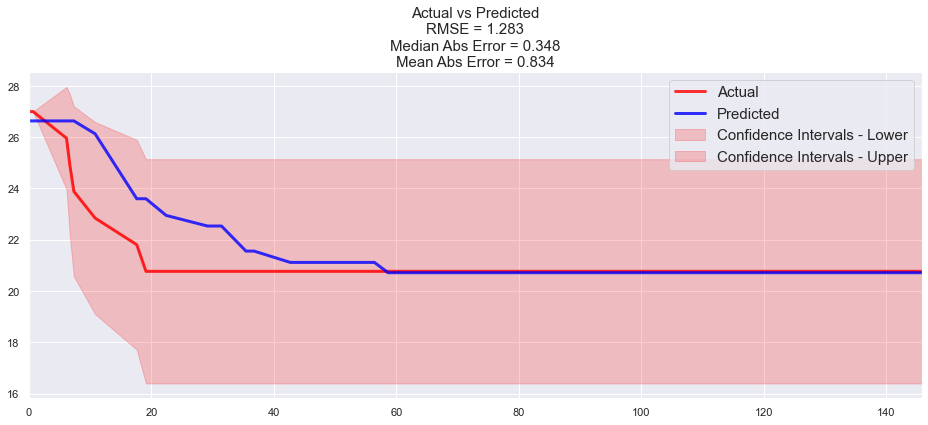

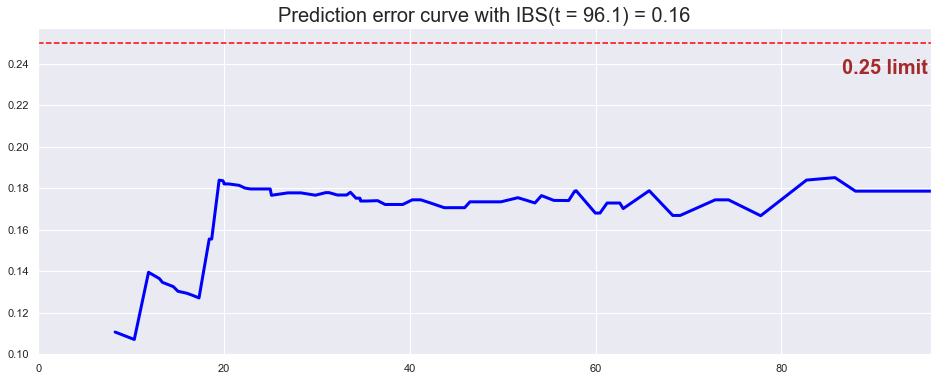

C-index: 0.71
IBS: 0.16

 2 of kfold 5


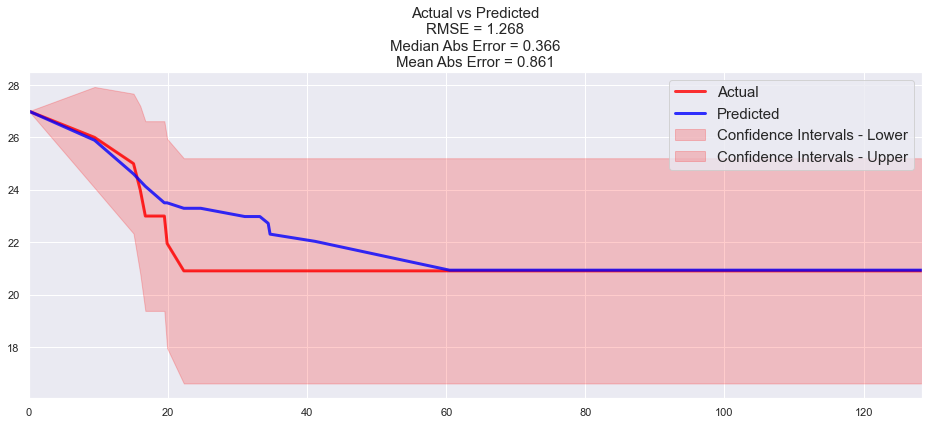

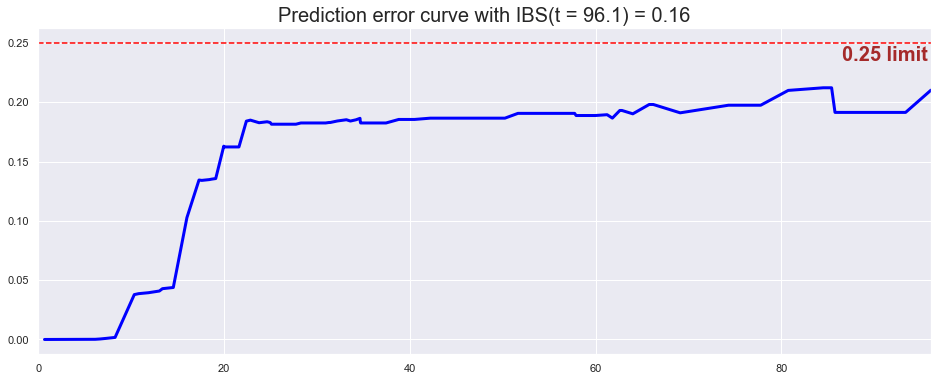

C-index: 0.50
IBS: 0.16

 3 of kfold 5


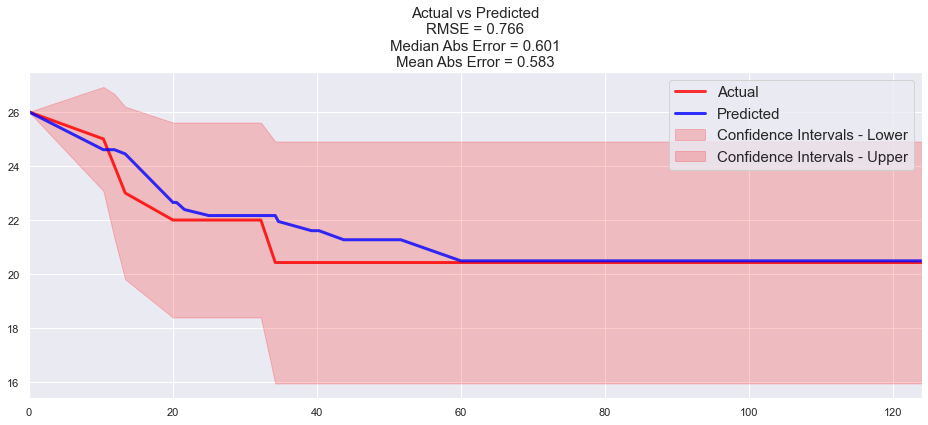

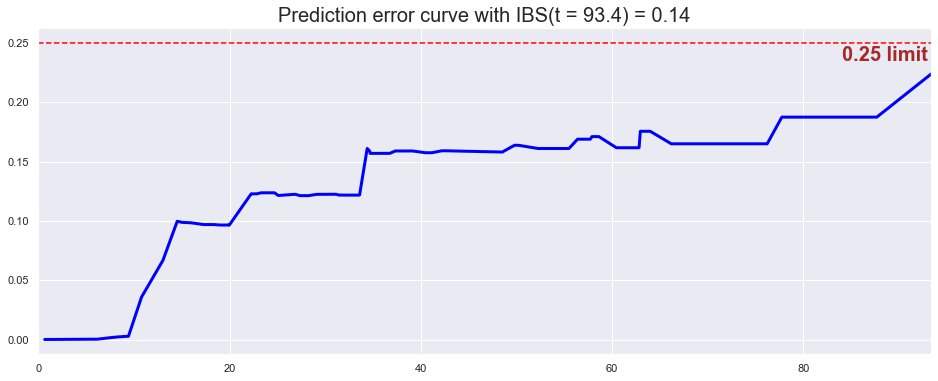

C-index: 0.87
IBS: 0.14

 4 of kfold 5


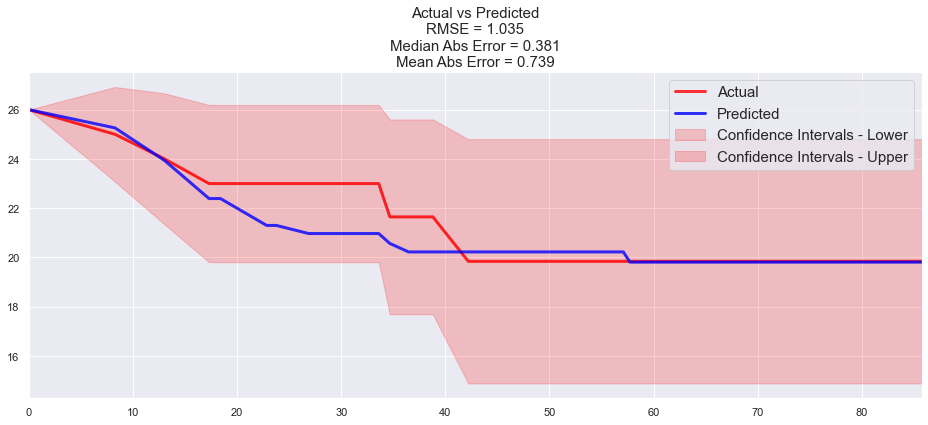

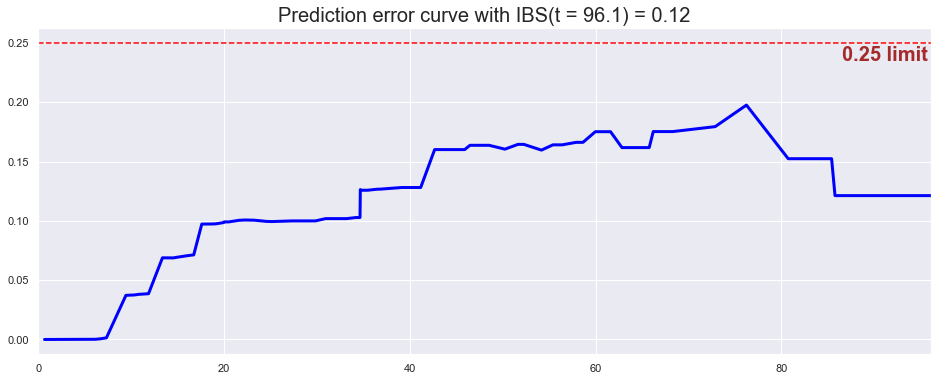

C-index: 0.88
IBS: 0.12

 5 of kfold 5


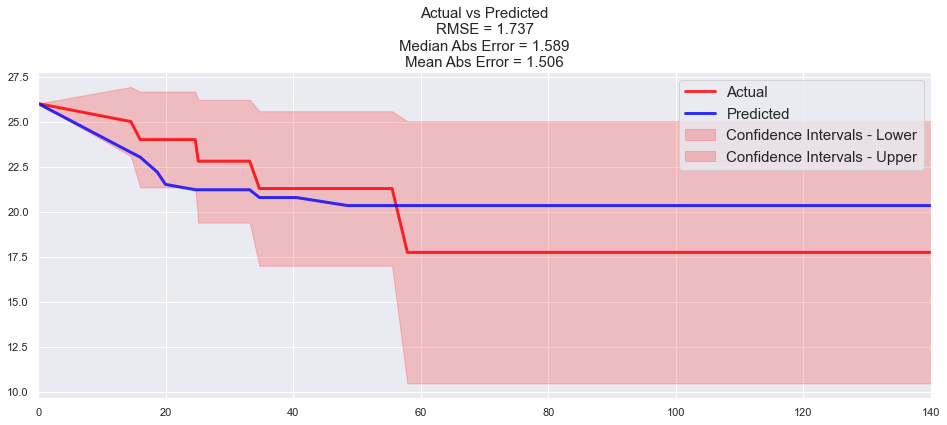

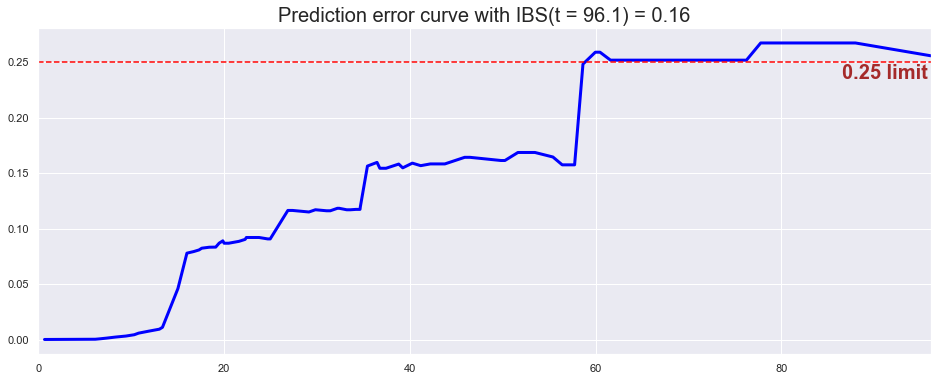

C-index: 0.72
IBS: 0.16

 

Processing: clin_var_only.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: clin_var_only.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 5


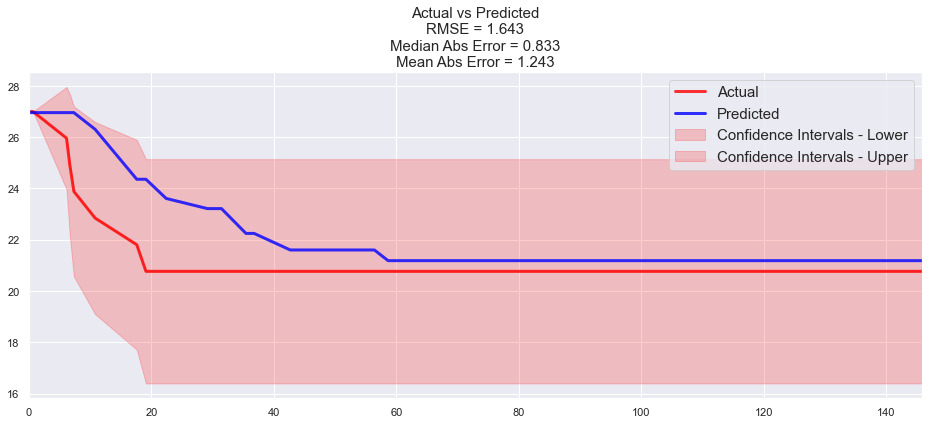

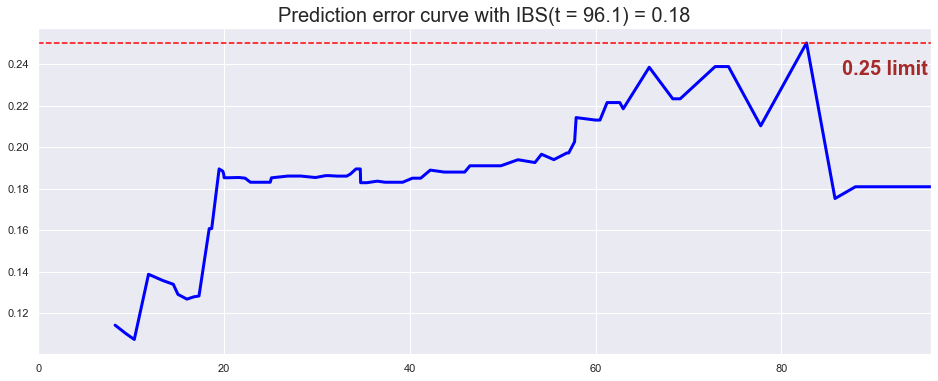

C-index: 0.51
IBS: 0.18

 2 of kfold 5


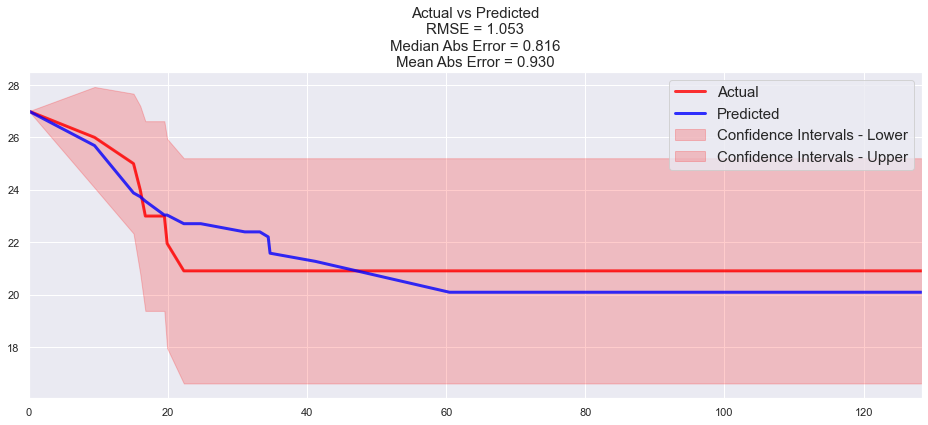

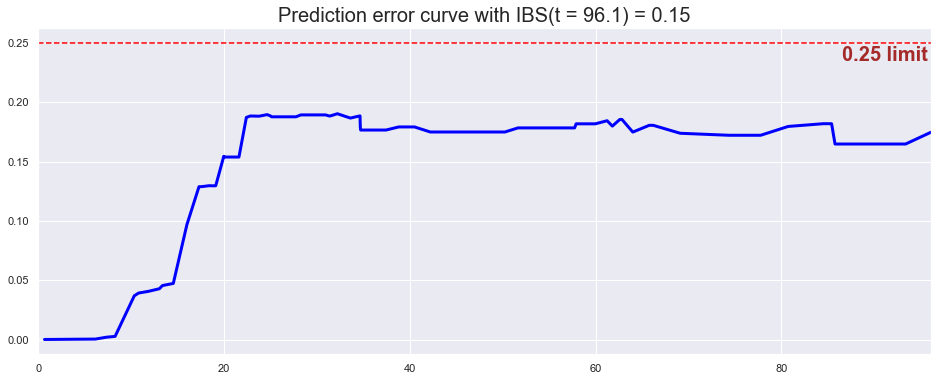

C-index: 0.55
IBS: 0.15

 3 of kfold 5


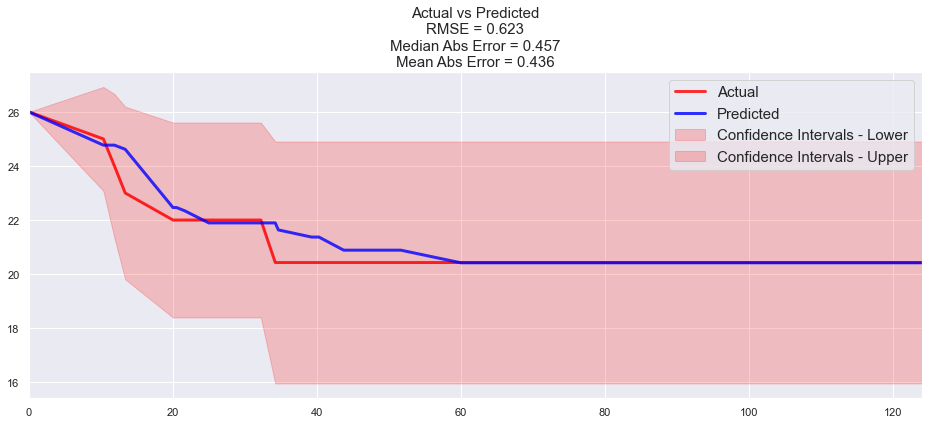

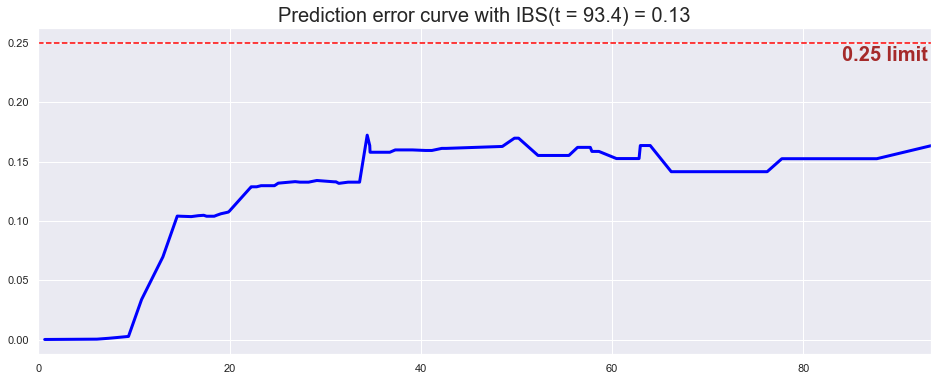

C-index: 0.69
IBS: 0.13

 4 of kfold 5


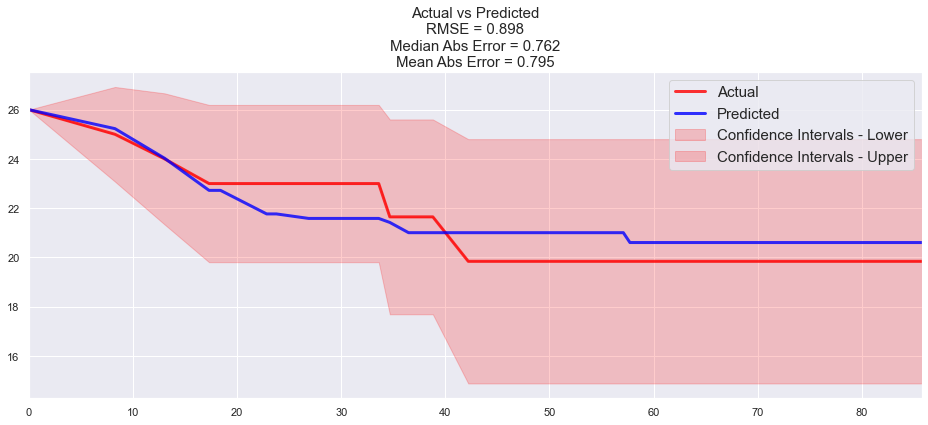

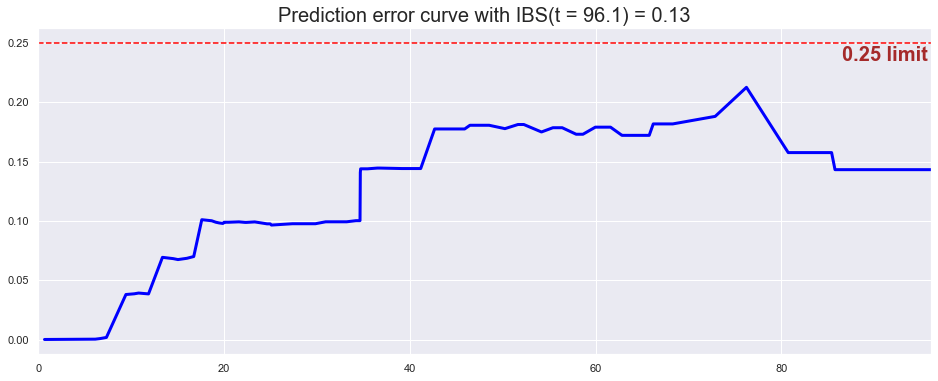

C-index: 0.61
IBS: 0.13

 5 of kfold 5


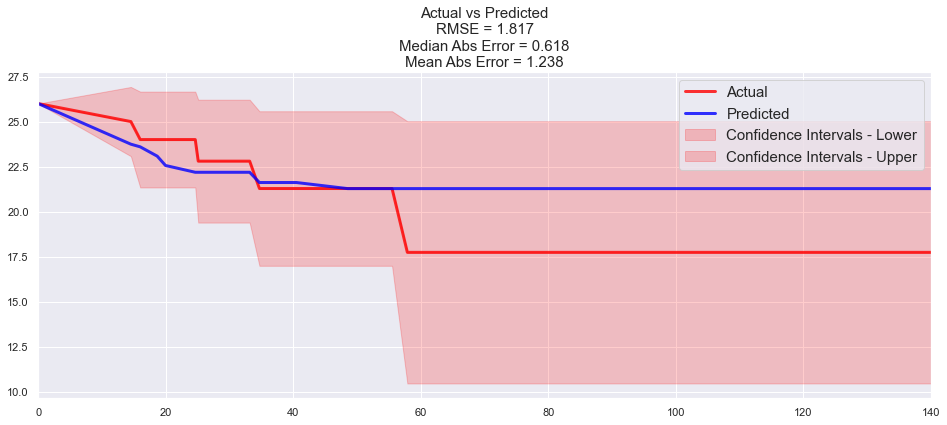

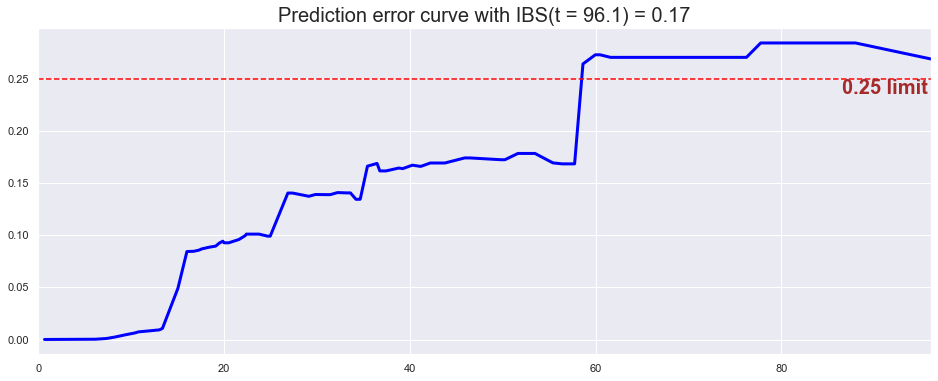

C-index: 0.70
IBS: 0.17

 

Processing: rad_and_clin_var.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: rad_and_clin_var.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 5


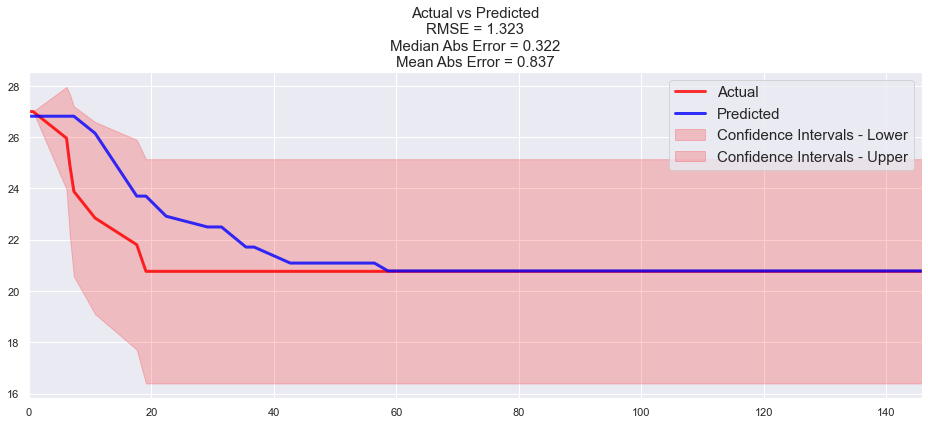

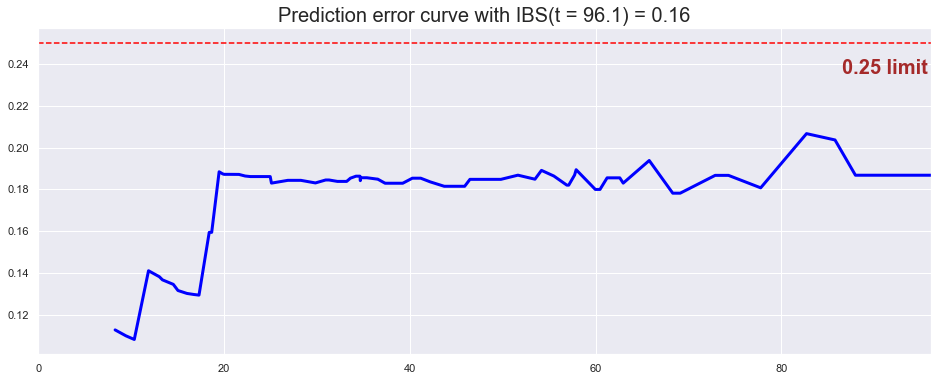

C-index: 0.61
IBS: 0.16

 2 of kfold 5


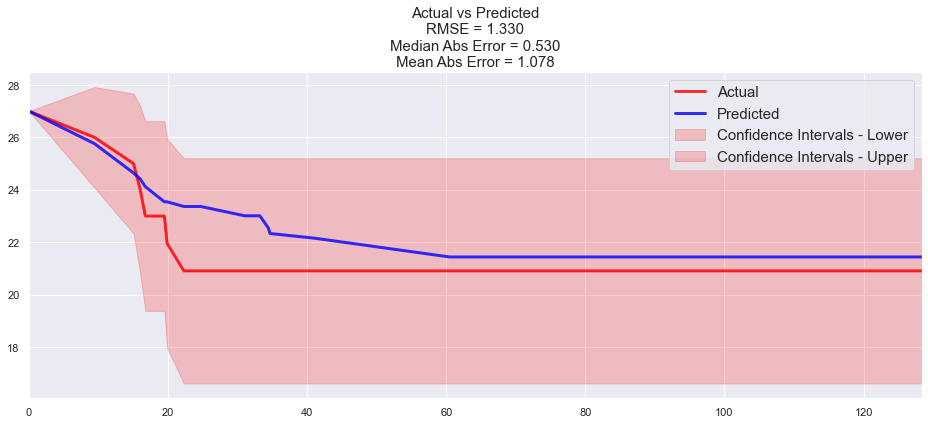

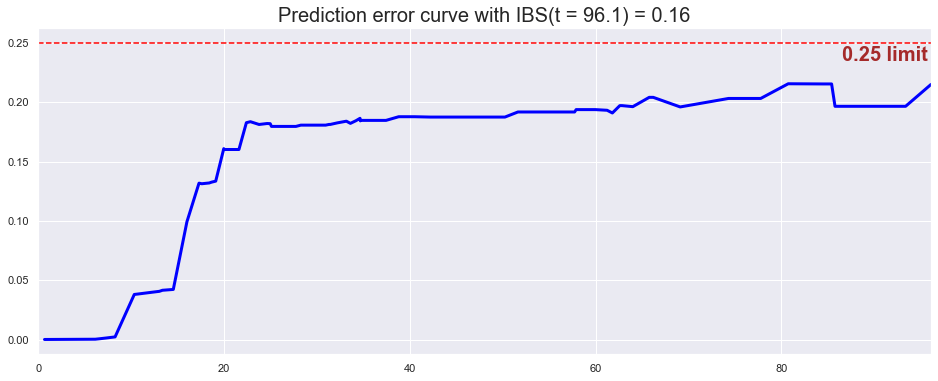

C-index: 0.58
IBS: 0.16

 3 of kfold 5


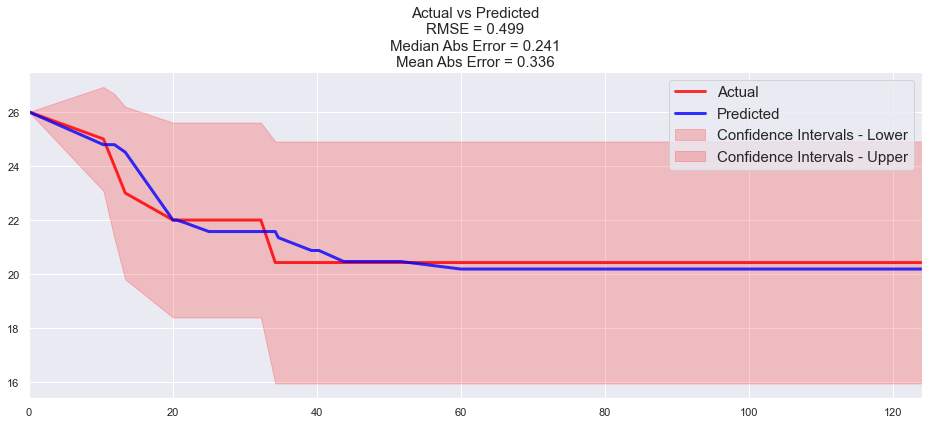

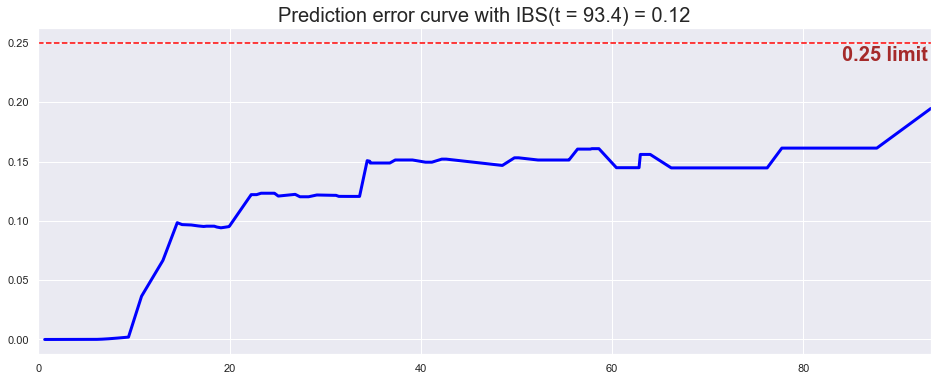

C-index: 0.88
IBS: 0.12

 4 of kfold 5


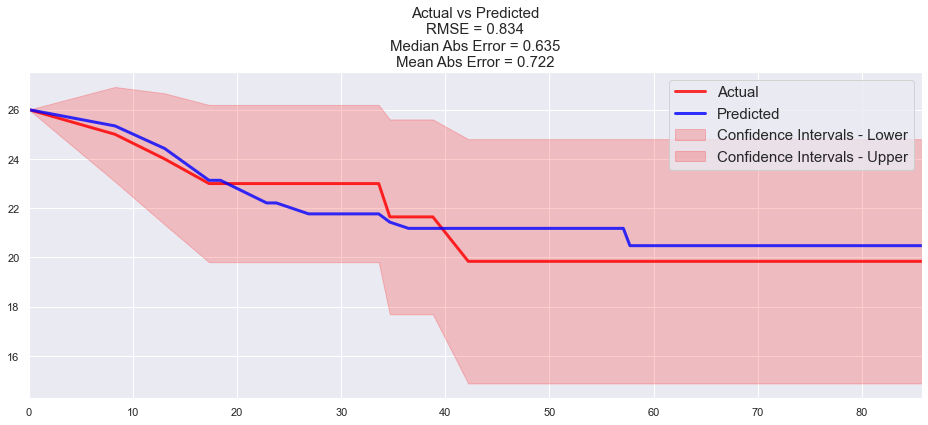

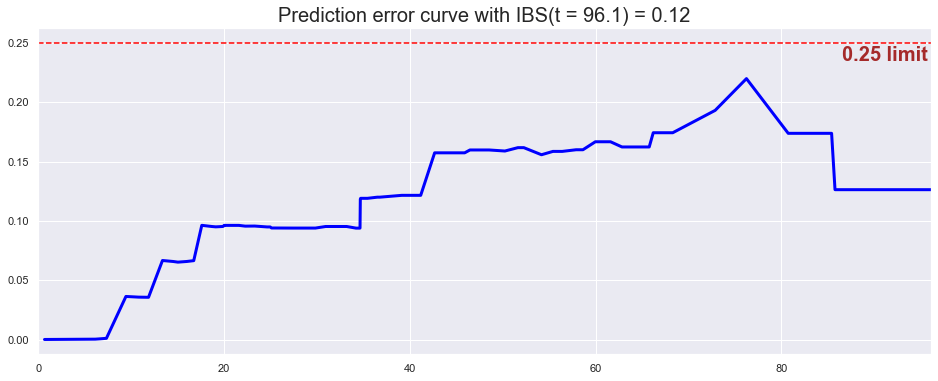

C-index: 0.86
IBS: 0.12

 5 of kfold 5


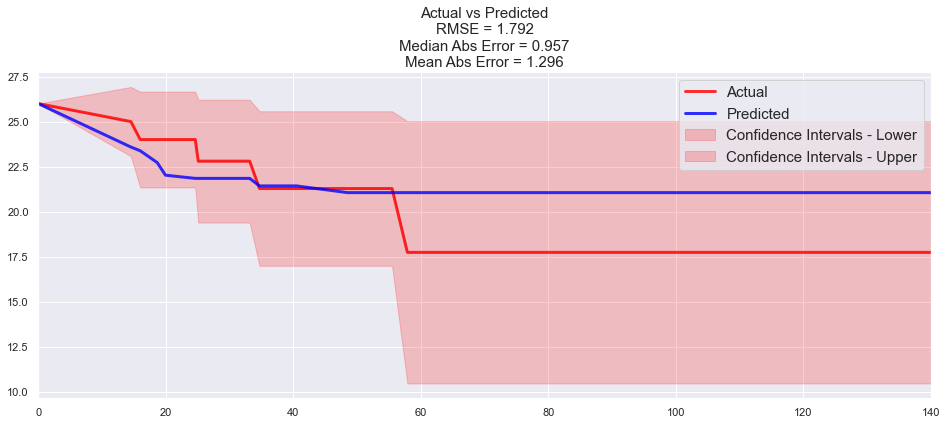

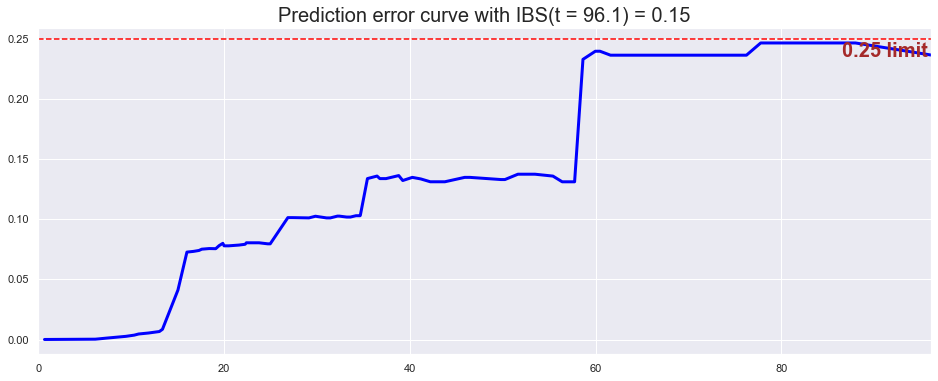

C-index: 0.52
IBS: 0.15

 



,Data,Best Gridsearch CI,CI Avg,CI STD,IBS Avg,IBS STD,Num Trees,Max Depth,Min Node
0,radiomics_only.csv,0.703333,0.736406,0.153010,0.147019,0.017314,25.0,1.0,20.0
1,clin_var_only.csv,0.683943,0.613427,0.082061,0.151202,0.023090,25.0,5.0,2.0
2,rad_and_clin_var.csv,0.739697,0.690053,0.167423,0.143997,0.019607,25.0,5.0,20.0


In [13]:
#scratchpad
results = []
    
for data_name in data_list:

    # Running feature selection on the data
    
    print('Processing: ' + data_name + '\n')
    processed_file_name = 'filtered_' + data_name 
    
    print('Feature Selecting... \n')
    if(not(os.path.exists(processed_file_name))):
        print('Computing feature selection...\n')
        filtered_data = feature_select(data_name)
    else:
        filtered_data = pd.read_csv(processed_file_name)
        print('Loading existing selected features...\n')
    print('\n \n')

    # running gridsearch
    
    print('Running gridsearch on: ' + data_name + '\n')
    gridsearch_file_name = 'gridsearch_' + data_name 
    
    if(not(os.path.exists(gridsearch_file_name))):
        print('Computing gridsearch...\n')
        (c_index_best, num_tree_best, max_depth_best, min_node_best) = gridsearch(filtered_data, data_name)
        print((c_index_best, num_tree_best,max_depth_best, min_node_best))
    else:
        gridsearch_df = pd.read_csv(gridsearch_file_name)
        
        c_index_best = gridsearch_df['Values'][0]
        num_tree_best = gridsearch_df['Values'][1]
        max_depth_best = gridsearch_df['Values'][2]
        min_node_best = gridsearch_df['Values'][3]
        
        #print(c_index_best)
        print('Loading existing gridsearch hyperparameters...\n')
        
    # generating model form best gridsearch combination

    print('Evaluating K-folds with best hyperparameter combination...\n')
    (CIAvg, CIStd, IBSAvg, IBSStd) = generate_survival_model(filtered_data, num_tree_best, max_depth_best, min_node_best)
    
    results.append([data_name, c_index_best, CIAvg, CIStd, IBSAvg, IBSStd, num_tree_best, max_depth_best, min_node_best])
    print('\n \n')

results_DF = pd.DataFrame(results, columns = ['Data', 'Best Gridsearch CI', 'CI Avg','CI STD','IBS Avg', 'IBS STD', 'Num Trees', 'Max Depth', 'Min Node'])

results_DF
